# fastReach Data Exploration

## Loading Data

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
import pickle

pID = '2'

path = '/Users/lukasgehrke/Documents/publications/2021-fastReach/data/study/eeglab2python/'
data_fname = '/data.csv'
data = pd.read_csv(path+pID+data_fname)

## Build feature matrix EEG

In [8]:
# import feature computation functions

# EEG features
# 1. windowed means over EEG channels
win_mean_size = 25
win_mean = np.arange(len(data))//win_mean_size

win_mean = data.groupby(win_mean).mean()

# # EMG features
# def rms(values):
#     return np.sqrt(sum(values**2)/len(values))

# emg = data.iloc[:,[0,3]]
# emg = emg.groupby(['epoch_ix'])["emg"].apply(rms)


# Train & Inspect Models

## EEG

In [11]:
clf = LDA()

a = win_mean.iloc[:,5:].values

clf.fit(win_mean.iloc[:,5:].values, win_mean.rp_class)
# print(clf.coef_)

# prediction = predict(feats.T)[0] #predicted class
# probs = predict_proba(feats.T) #probability for class prediction

# splits data randomly in n=folds 
kfolds = KFold(n_splits=10, random_state=1, shuffle=True) 

eeg_dim1 = 5
cv_results = cross_val_score(clf, data.iloc[:,eeg_dim1:].values, data.rp_class, cv=kfolds)
cv_average = cv_results.mean()
print(cv_average)
st_deviation = cv_results.std()

filename = path+pID+'/model_'+pID+'_eeg.sav'
pickle.dump(clf, open(filename, 'wb'))


0.7682857142857142


## Motion

In [13]:
clf = LDA()

# feat = win_mean.iloc[:,2].values
# clf.fit(feat.reshape(-1, 1), win_mean.rp_class)

motion_dim = 3
clf.fit(data.iloc[:,motion_dim].values.reshape(-1,1), data.rp_class)

# splits data randomly in n=folds 
kfolds = KFold(n_splits=10, random_state=1, shuffle=True) 

# cv_results = cross_val_score(clf, feat.reshape(-1, 1), win_mean.rp_class, cv=kfolds)
cv_results = cross_val_score(clf, data.iloc[:,3].values.reshape(-1,1), data.rp_class, cv=kfolds)
cv_average = cv_results.mean()
print(cv_average)
st_deviation = cv_results.std()

filename = path+pID+'/model_'+pID+'_motion.sav'
pickle.dump(clf, open(filename, 'wb'))

0.9122857142857143


# Plots

## Features

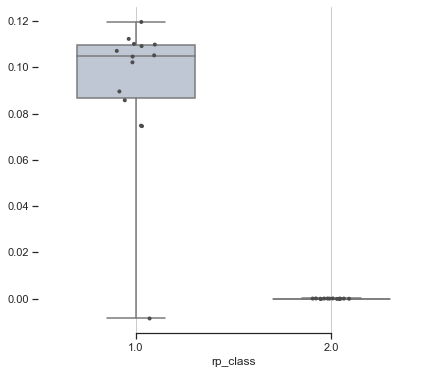

In [21]:
# g = sns.lmplot(x='Motion',y='Motion', data=data, hue='rp_class', fit_reg=False)
# g.set_axis_labels('{} muscle1'.format(feature), '{} muscle2'.format(feature))

data_short = data.groupby(['epoch_ix']).mean()

sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 6))

# Plot the orbital period with horizontal boxes
group_var = "rp_class"
val_var = "Motion"
sns.boxplot(x=group_var, y=val_var, data=data_short,
            whis=[0, 100], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x=group_var, y=val_var, data=data_short,
              size=4, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)


## Linear Discriminant(s) Plot

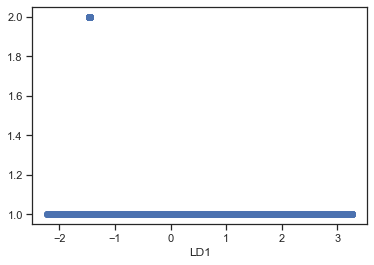

In [76]:
clf = LDA(n_components=1)
# data.loc[0,:]=np.zeros(data.shape[1])
# data_short = data.grouby(['epoch_ix']).mean()

transf_lda = clf.fit_transform(data.iloc[:,3].values.reshape(-1,1), data.rp_class)

# print(transf_lda)

plt.xlabel('LD1')
# plt.ylabel('LD2')
plt.scatter(
    x=transf_lda[:,0],
    y=data.rp_class,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)

# import matplotlib.pyplot as plt
# for label,marker,color in zip(range(1,3),('o','^'),('red','blue')):
#     plt.scatter(x=transf_lda[:,0][data.rp_class == label],
#            y=[data.rp_class == label], marker=marker,
#            color=color, alpha=0.7, label='class {}'.format(label))

# #plt.xlabel('vector 1')
# #plt.ylabel('vector 2')

# plt.legend(loc='lower right')
# plt.title('dimensionality reduction for data set')

# plt.show()

## ERP Readiness Potential Plot

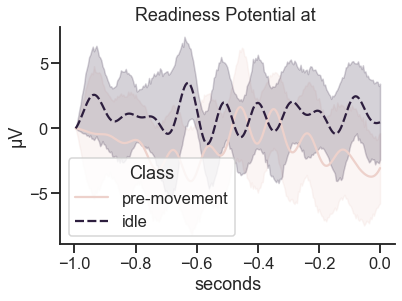

In [14]:
sns.set_theme(style="ticks")
sns.set_context("talk")

# Plot the responses for different events and regions
g = sns.lineplot(x="sample", y="Pz",
             hue="rp_class", style="rp_class",
             data=data)
sns.despine()

electrode = ""
g.set(xlabel='seconds', ylabel='\u03bcV', title='Readiness Potential at '+electrode)

# legend
leg = g.legend_
new_title = 'Class'
leg.set_title(new_title)
# replace labels
new_labels = ['pre-movement', 'idle']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)